In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
sns.set_style('darkgrid')

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [2]:
# user-made
sys.path.append('../scripts')
from tools.preprocess import cut_seq, preprocess_seq, to_return

## Preprocess

In [4]:
# load train data
train_full = np.load('../data_coin-price/train.npy')

isMini = True
if isMini:
    idx = np.random.randint(train_full.shape[0], size=1000)
    train_full = train_full[idx, :, :]

train_full.shape

(1000, 1500, 10)

In [5]:
# train, val split
train, val = train_test_split(train_full, random_state=1)
train.shape, val.shape

((750, 1500, 10), (250, 1500, 10))

In [6]:
# create training instances(windows)

SRC_LEN, TGT_LEN = 300, 10
STRIDE = 5

def preprocess_composed(data):
    input, target = preprocess_seq(data, index=1)   

    # to return
    input = to_return(input)
    target = to_return(target) 

    # cut seq
    input = cut_seq(input, window_len=SRC_LEN+TGT_LEN, stride=STRIDE)
    target = cut_seq(target, window_len=SRC_LEN+TGT_LEN, stride=STRIDE)

    # to tensor
    input= torch.Tensor(input)
    target = torch.Tensor(target)

    # divide into src and tgt (input will be divided in training loop)
    target = target[:, SRC_LEN:, :]

    return input, target

In [7]:
# DataLoader
BATCH_SIZE = 64

input, target = preprocess_composed(train)
train_dset = TensorDataset(input, target)
train_dloader = DataLoader(train_dset, shuffle=True, batch_size=BATCH_SIZE)
print('Number of training instances:', len(train_dset))

input, target = preprocess_composed(val)
val_dset = TensorDataset(input, target)
val_dloader = DataLoader(val_dset, shuffle=False, batch_size=BATCH_SIZE)

Number of training instances: 178500


## Train

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
from model.model import Transformer_fcst

# model
model = Transformer_fcst(fcst_mode='gauss',
                         seq_len=(SRC_LEN, TGT_LEN),
                         embedding_dim=64,
                         nhead=8,
                         num_layers=(2,2),
                         device=device,
                         ts_embed_mode='wavenet',
                         pos_embed_mode='fixed',
                         dilation_list=(1,2,4,1,2,4)).to(device)

TypeError: __init__() got an unexpected keyword argument 'dilation_list'

In [25]:
from tools.train import EarlyStopping

print(f'BATCH_SIZE:{BATCH_SIZE}')
print(f'SRC_LEN:{SRC_LEN}')
print(f'TGT_LEN:{TGT_LEN}')
print(f'STRIDE:{STRIDE}')   
print(f'isMini:{isMini}')

# config
criterion = nn.GaussianNLLLoss()
metric_func = nn.MSELoss()
#criterion = nn.MSELoss()


optimizer = torch.optim.Adam(model.parameters() ,lr=1e-3, betas=(0.9, 0.98), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

PATIENCE = 5
es = EarlyStopping(patience=PATIENCE)
print(f'EarlyStopping patience:{PATIENCE}')

# train
n_epoch = 20
print(f'EPOCH:{n_epoch}')

train_loss_list = torch.zeros(n_epoch, device=device)
val_loss_list = torch.zeros(n_epoch, device=device)
train_mse_list = torch.zeros(n_epoch, device=device)
val_mse_list = torch.zeros(n_epoch, device=device)

print('Started training')

for epoch in range(n_epoch):
    model.train()
    running_train_loss = 0.0
    running_train_mse = 0.0

    for i, data in enumerate(tqdm(train_dloader)):
        input, target = data[0].to(device), data[1].to(device)
        src, tgt = input[:, :SRC_LEN, :], input[:, SRC_LEN:, :]

        optimizer.zero_grad()
        
        mean, var = model(src, tgt)
        loss = criterion(mean, target, var)
        mse = metric_func(mean, target)
        #forecast = model(src, tgt)
        #loss = criterion(forecast, target)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        running_train_mse += mse.item()

    # training loss
    train_loss = running_train_loss / len(train_dloader)
    train_loss_list[epoch] = train_loss
    print(f'[Epoch {epoch+1}] Train loss:', f'{train_loss:.4f}', end=' ')

    # metric
    train_mse = running_train_mse / len(train_dloader)
    train_mse_list[epoch] = train_mse
    print('Train MSE:', f'{train_mse}', end=' ')

    scheduler.step()
    

    # validation
    running_val_loss = 0.0
    running_val_mse = 0.0

    with torch.no_grad():
        model.eval()
        
        for i, data in enumerate(val_dloader):
            input, target = data[0].to(device), data[1].to(device)
            src, tgt = input[:, :SRC_LEN, :], input[:, SRC_LEN:, :]

            mean, var = model(src, tgt)
            loss = criterion(mean, target, var)
            mse = metric_func(mean, target)
            #forecast = model(src, tgt)
            #loss = criterion(forecast, target)

            running_val_loss += loss.item()
            running_val_mse += mse.item()
        
        val_loss = running_val_loss / len(val_dloader)
        val_loss_list[epoch] = val_loss
        print('Val loss:', f'{val_loss:.4f}', end=' ')

        val_mse = running_val_mse / len(val_dloader)
        val_mse_list[epoch] = val_mse
        print('Val MSE:', f'{val_mse}')

    # early stopping
    es(val_loss, model, '../_model_pkls')
    if es.early_stop:
        print('Early stopping')
        break

BATCH_SIZE:64
SRC_LEN:300
TGT_LEN:10
STRIDE:5
isMini:True
EarlyStopping patience:5
EPOCH:20
Started training
100%|██████████| 2790/2790 [15:57<00:00,  2.92it/s]
[Epoch 1] Train loss: -5.1952 Train MSE: 0.004026894639744489 Val loss: -5.9161 Val MSE: 2.668554975762175e-06
100%|██████████| 2790/2790 [16:54<00:00,  2.75it/s]
[Epoch 2] Train loss: -5.7905 Train MSE: 3.320146266954627e-06 Val loss: -5.9002 Val MSE: 2.6498253450641843e-06
EarlyStopping counter: 1 out of 5
100%|██████████| 2790/2790 [15:52<00:00,  2.93it/s]
[Epoch 3] Train loss: -5.7882 Train MSE: 3.3197813042728068e-06 Val loss: -5.9174 Val MSE: 2.6517842997849637e-06
 56%|█████▌    | 1551/2790 [08:48<07:02,  2.93it/s]


KeyboardInterrupt: 

## History
* 64, 8, (2,2) : -5.9
* 64, 8, (4,4) : -5.9

Text(0, 0.5, 'NLL')

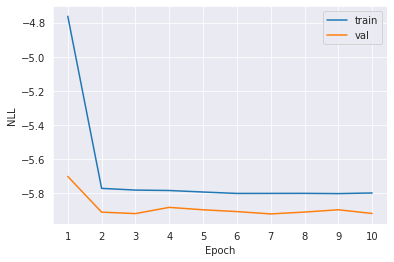

In [20]:
# Plot loss
train_loss_list_detached = train_loss_list.cpu().detach().numpy()
val_loss_list_detached = val_loss_list.cpu().detach().numpy()

train_loss_list_detached = train_loss_list_detached[train_loss_list_detached != 0]
val_loss_list_detached = val_loss_list_detached[val_loss_list_detached != 0]

xticks = np.arange(1, len(train_loss_list_detached)+1)
plt.plot(xticks, train_loss_list_detached, label='train')
plt.plot(xticks, val_loss_list_detached, label='val')
plt.legend()
plt.xticks(xticks, xticks)
plt.xlabel('Epoch')
plt.ylabel('NLL')

In [21]:
# load the best model (early stopping)
model.load_state_dict(torch.load('../_model_pkls/checkpoint.pth'))

<All keys matched successfully>

## Plot evaluation

In [22]:
from tools.infer import plot_eval_point, plot_eval_gauss

# get a single batch from val_dloader
sample = next(iter(train_dloader))

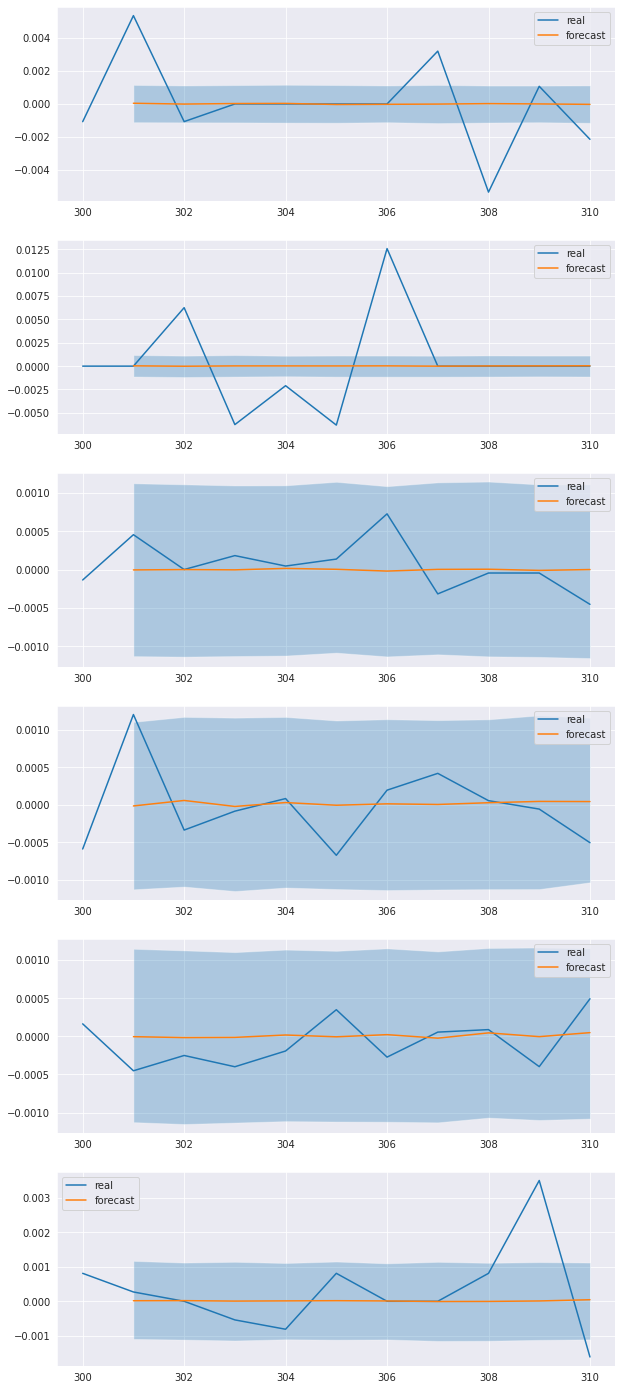

In [23]:
# short-term (rolling-minute prediction); gauss

## forward
model.eval()

input, target = sample[0].to(device), sample[1].to(device)
src, tgt = input[:, :SRC_LEN, :], input[:, SRC_LEN:, :]
mean, var = model(src, tgt)

## to numpy array
input = input.cpu().detach().numpy()
target = target.cpu().detach().numpy()
mean = mean.cpu().detach().numpy()
var = var.cpu().detach().numpy()
sample_nums = np.random.choice(BATCH_SIZE, 6)

## plot
fig, axs = plt.subplots(6,1, figsize=(10,25))

for i, sample_num in enumerate(sample_nums):
    input_ = input[sample_num].squeeze(-1)
    target_ = target[sample_num].squeeze(-1)
    mean_ = mean[sample_num].squeeze(-1)
    var_ = var[sample_num].squeeze(-1)

    plot_eval_gauss(input_, target_, mean_, var_, axs[i], cut_head=300, quantile=0.5)